# Johansen cointegration test: theory and practice
This Notebook intends to serve as a guide for understanding the Johansen cointegration test from scratch. It combines the theory and mathematical background required to understand the test as well as code snippets exemplifying the use of each feature.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_order

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##1 Generalization of the cointegration concept to more than two series
We know the concept and definition of cointegration from [Introduction to cointegration](https://colab.research.google.com/drive/11csRmKnfbVyB-85skTJE6QpKuUoMs2b4).

Just as a quick reminder, we say a time series is integrated of order d or $I(d)$ if we need to apply $d$ differences to make it stationary or $I(0)$. Two time series $x_t$ and $y_t$, both of them $I(d)$, are said to be cointegrated if there exists a linear combination of them with and order of cointegration lower than $d$. That is, if it is possible to find $n_t^*=\alpha_1y_t+\alpha_2x_t$ where $n_t^*$ is a time series $I(d_1)$ with $d_1 < d$ and $\alpha_1, \alpha_2 \in\mathbb{R}$.

We refer to the combination ($\alpha1, \alpha2$) as a **cointegration relationship**. This cointegration relationship is not unique, since ($k\alpha1, k\alpha2$) also denotes a cointegration relationship for every $k\neq0$.

However, we can generalize cointegration to the case when there are more than 2 vectors in a cointegration relationship. If we denote **$Y$** to be a $(t, m)$ array composed by an $m$ number of $(t, 1)$ $I(1)$ vector time series, there may exist $k (< m)$ linearly independent $(1, m)$ vectors $\beta_1, \beta_2, ..., \beta_k$ forming a $(k, m)$ matrix $𝚩$ which is denoted as cointegrating matrix if $𝚩Y^t \sim I(0)$ with $𝚩Y^t$ being $k$ vectors of size $(1, t)$. The number of linearly independent cointegrating vectors $k$ is called the cointegration rank.

In the particular case of two time series, **$Y$** would be an array composed by $x_t$ and $y_t$ and $m=2$. Since $k< m$, $k$ must be 1 (if the series are cointegrated) or zero otherwise. If the series are cointegrated the cointegrating matrix collapses to a vector $\beta_1$ of size $(1, 2)$ and the cointegration rank is one. In this case $𝚩Y^t$ outputs the residuals from the regression seen when covering the Engle-Granger approach.

##2 The Granger-Engle Representation Theorem
The Granger-Engle Representation Theorem proves that system with cointegrated $I(1)$ variables can be equivalently represented as a Common Trends model, Moving Average (MA) model or as a Equilibrium Correction inside an Error Correction Model (ECM). They start expressing the variables as a VAR and then prove the equivalency to a ECM.

### 2.1 VAR (Vector Autoregression)
Vector Autoregression or VAR is the generalization to multivariate time series of the concept of auto regressive model from univariate time series.
VAR is a statistical model used to capture the relationship between multiple quantities as they change over time. 

Broadly speaking, VAR models can be of several types:


*   **Reduced VAR.** Each variable is only a function of its own past values and the past values of other variables in the model.
*   **Recursive VAR.** The model includes all the relationships from the reduced VAR, but also allow for some variables to be a function of the current vale of other variables. This way the model allows for structural shocks.
*   **Structural VAR.** These models include restrictions modelling causal relationships beyond those identified in reduced or recursive models. These causal relationships can be used to model and forecast impacts of individual shocks, such as policy decisions.





### 2.2 Equilibrium correction representation (ECM)
An error correction model (ECM) belongs to a category of multiple time series models most commonly used for data where the underlying variables have a long-run common stochastic trend, also known as cointegration. ECMs are a theoretically-driven approach useful for estimating both short-term and long-term effects of one time series on another. 

The term error-correction relates to the fact that last-period's deviation from a long-run equilibrium, the error, influences its short-run dynamics. Thus ECMs directly estimate the speed at which a dependent variable returns to equilibrium after a change in other variables.

To derive the ECM from the VAR, we can consider a bivariate $VAR(1)$: $\textbf{x}_t=Φ\textbf{x}_{t-1}+ 𝜀_t$ where $\textbf{x}_t=(x_t, y_t)$, $Φ$ is a $(2, 2)$ coefficient matrix and $𝜀_t$ is a matrix with two gaussian noise time series.

The characteristic equation of $Φ$ is: $|Φ-zI|=0$. If we have two unit roots in the characteristic equation, this implies that there is no cointegration. If we have two stationary roots then the original $\textbf{x}_t$ series are already stationary. Therefore, we are interested in the case when only some of the roots are stationary; this is the case where cointegration is present. As a consequence, we can write the two characteristic roots as: $z_1=1$ and $z_2=λ, |λ|< 1$.

Since both eigenvalues are different from zero, $Φ$ can be diagonalized in terms of its eigenvalues and their corresponding eigenvectors in the following way: $Φ=\textbf{P}\begin{pmatrix} 1 & 0 \\ 0 & λ \end{pmatrix} \textbf{P}^{-1}$ where $\textbf{P}$ is the $Φ$ matrix with eigenvectors as columns: $\textbf{P}=\begin{pmatrix} α & β \\ γ & δ \end{pmatrix}$.

If we assume without loss of generality that $|\textbf{P}|=1$, then developing the determinant implies $αδ-γβ=1$ and then $\textbf{P}^{-1}=\begin{pmatrix} δ & -β \\ -γ & α \end{pmatrix}$.

Substituting in the expression above we get the following expression for $Φ$: 

$Φ=
\textbf{P} \begin{pmatrix} 1 & 0 \\ 0 & λ \end{pmatrix} \textbf{P}^{-1}=
\begin{pmatrix} α & β \\ γ & δ \end{pmatrix} \begin{pmatrix} 1 & 0 \\ 0 & λ \end{pmatrix} \begin{pmatrix} δ & -β \\ -γ & α \end{pmatrix} =
\begin{pmatrix} αδ −λβγ & −αβ(1 −λ) \\ γδ(1 −λ) & −γβ + λαδ \end{pmatrix}$

We can decompose this matrix in the following way:

$Φ=
\begin{pmatrix}αδ −λβγ & −αβ(1 −λ) \\ γδ(1 −λ) & −γβ + λαδ \end{pmatrix}=
\begin{pmatrix} αδ −γβ +γβ −λβγ & −αβ(1 −λ) \\ γδ(1 −λ) & −γβ +αδ -αδ + λαδ \end{pmatrix}$

But from the determinant expression we know $αδ-γβ=1$. Therefore, we can reorder terms and express the matrix above as:

$Φ=
\begin{pmatrix} 1 +γβ −λβγ & −αβ(1 −λ) \\ γδ(1 −λ) & 1 -αδ + λαδ \end{pmatrix}=
\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} + \begin{pmatrix} γβ −λβγ & −αβ(1 −λ) \\ γδ(1 −λ) & -αδ + λαδ \end{pmatrix}=
\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} + (1-λ)\begin{pmatrix} γβ & −αβ \\ γδ & -αδ \end{pmatrix}=
\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} + (1-λ)\begin{pmatrix} β \\ δ \end{pmatrix}\begin{pmatrix} γ & -α \end{pmatrix}$

Going back to the VAR expression we find that, using $Φ$ as the coefficients matrix, we can express:

${x}_t=Φ\textbf{x}_{t-1}+ 𝜀_t \Rightarrow 
\begin{pmatrix} Δ x_t \\ Δy_t \end{pmatrix} = (1-λ)\begin{pmatrix} β \\ δ \end{pmatrix}\begin{pmatrix} γx_{t-1} & -α_{t-1} \end{pmatrix} + 𝜀_t$.

This expression can be written as:

$\begin{pmatrix} Δ x_t \\ Δy_t \end{pmatrix} = \textbf{α}\textbf{β}^t \begin{pmatrix} x_{t-1} \\ y_{t-1} \end{pmatrix} + 𝜀_t = 
Δ \textbf{x}_t = \textbf{α}\textbf{β}^t \textbf{x}_{t-1} + \textbf{𝜀}_t$

In this expression $\textbf{α}$ represents the vector of equilibrium correction coefficients $\begin{pmatrix} (1-λ)β \\ (1-λ)δ \end{pmatrix} = 
\begin{pmatrix} α_{11} \\ α_{21} \end{pmatrix}$ and $\textbf{β}$ represents the cointegration vector $\begin{pmatrix} γ \\ -α \end{pmatrix}$.

When we work with VAR models we usually express the above expression as $Δ \textbf{x}_t = \textbf{Π} \textbf{x}_{t-1} + \textbf{𝜀}_t$ where $\textbf{Π}=\textbf{α}\textbf{β}^t=\textbf{Φ}-\textbf{I}$


### 2.3 Conclusion

The above development shows a close relationship between the eigenvalues of $\textbf{Π}$, is rank and the existence of cointegration. Considering again a bivariate $VAR(1)$ we may find three different scenarios:


*   $rank(\textbf{Π})=0$. Both eigenvalues are zero, $\textbf{Π}$ has reduced rank and there is no cointegration.
*   $rank(\textbf{Π})=1$. One eigenvalue is different from zero, $\textbf{Π}$ has reduced rank but there is cointegration.
*   $rank(\textbf{Π})=2$. Both eigenvalues are different from zero, $\textbf{Π}$ has full rank and the VAR is already stationary.

The Johansen test is precisely the methodology to test whether the eigenvalues of $\textbf{Π}$ are significantly different from zero.



##3 Johansen cointegration test
One of the key benefits from the Johansen test is that it can be used to check for cointegration between a maximum of 12 time series, whereas the Engle-Granger approach could only be used with two time series. This implies that a stationary linear combination of assets can be created by using more than two time series. 

In addition, the Engle Granger test is not symmetrical, meaning that changes in the orderin of the two time series may result in different conclusions on the existence of cointegration. However, the variable treatment in the Johansen test is symmetrical, assuring homogeneity of results regardless of the input ordering.

Finaly, Johansen tests for the existence of cointegration and estimates the cointegrating vectors in one step. This avoids rounding errors from taking one step to calculate the cointegration vector and another one to test for cointegration as it is the case in the Engle-Granger approach.

The Johansen test for cointegration is based on the maximum likelihood estimator of the reduced rank model (generated by imposing rank restrictions on the VAR model).

###3.1 Johansen estimator for the cointegrating vectors
The Johansen's method starts with the VAR(k) model $Δy_t=μ+\sum_{i=1}^{k-1}Γ_iΔy_{t-i}+Πy_{t-k}+e_t$ where $Π=αβ^t$ under the assumption of cointegration or order $k$.

First we define three variables: $Z_{0t}=ΔX_t$, $Z_{1t}=X_{t-1}$ and $Z_{2t}=\begin{pmatrix} ΔX_{t-1}^t & ΔX_{t-2}^t & ... & ΔX_{t-k+1}^t \end{pmatrix}$. Besides, we define $Ψ$ to be the matrix of parameters corresponding to $Z_{2t}$, that is, the matrix consisting of $\begin{pmatrix}Γ_1 & Γ_2 & ... & Γ_{k-1}\end{pmatrix}$.

This variables allow us to rewrite the model as $Z_{0t}=αβ^tZ_{1t}+ΨZ_{2t}+ε_t$ which is a non-linear regression model where the parameters $Ψ$ are unrestricted and the coefficient matrix to the levels $αβ^t$ is of reduced rank.

From the log likelihood function we get that the first order conditions for estimating $Ψ$ are given by $\sum_{t=1}^T(Z_{0t}-αβ^tZ_{1t}-\hat{Ψ}Z{2t})Z_{2t}^t=0$. Now we need to define the product moment matrices $M_{ij}=\frac{1}{T}\sum_{t=1}^TZ_{it}Z_{jt}^t$ for $i,j=0, 1, 2$ (noting that $M_{ij}=M_{ji}^t$).

Using the product moment matrix notation we can rewrite the first order conditions for estimating $Ψ$ as $M_{02}=αβ^tM_{12}+\hat{Ψ}M_{22}  \Leftrightarrow \hat{Ψ}=M_{02}M_{22}^{-1}-αβ^tM_{12}M_{22}^{-1}$. 

Now we can calculate the residuals from regressing $ΔX_t$ and $X_{t-1}$ on the lagged differences $ΔX_{t-1}^t, ΔX_{t-2}^t, ..., ΔX_{t-k+1}^t$ (or $Z_{0t}$ and $Z_{1t}$ on $Z_{2t}$). Since $\hat{β}=(X^tX)^{-1}X^tY$ in an OLS regression, this residuals can be calculated as:

$R_{0t}=Z_{0t}-M_{02}M_{22}^{-1}Z_{2t}$\
$R_{1t}=Z_{1t}-M_{12}M_{22}^{-1}Z_{2t}$

From this residual expressions we can take out $Z_{0t}$ and $Z_{1t}$: 

$Z_{0t}=R_{0t}+M_{02}M_{22}^{-1}Z_{2t}$\
$Z_{1t}=R_{1t}+M_{12}M_{22}^{-1}Z_{2t}$

And we know from above $\hat{Ψ}=M_{02}M_{22}^{-1}-αβ^tM_{12}M_{22}^{-1}$. 

Substituting in the first order condition for estimating $Ψ$ we have:

$(Z_{0t}-αβ^tZ_{1t}-\hat{Ψ}Z{2t})Z_{2t}^t=0 \Leftrightarrow 
[R_{0t}+M_{02}M_{22}^{-1}Z_{2t}-αβ^t(R_{1t}+M_{12}M_{22}^{-1}Z_{2t})-(M_{02}M_{22}^{-1}-αβ^tM_{12}M_{22}^{-1})Z_{2t}]=0 \Leftrightarrow
R_{0t}-αβ^tR_{1t}=0   \Leftrightarrow  R_{0t} = αβ^tR_{1t}$

This implies that $Ψ$ can be eliminated by regression and the only model remaining in the above expression is a reduced rank regression, given the reduced rank of $αβ^t$ due to the cointegration assumption. This process can also be interpreted as cleaning out $ΔX$ and $X_{t-k}$ from the short-run parameters, which can be considered noise in the cointegration relationship.

The last elements we need to define are the sum of squares from regressing $Z_{0t}$ and $Z_{1t}$ on $Z_{2t}$: $S_{ij}=\frac{1}{T}\sum_{t=1}^T R_{it}R_{jt}^t=M_{ij}-M_{i2}M_{22}^{-1}M_{2j}$ for $i,j=0,1$.

Therefore the maximum likelihood estimator of $α$ and $β$ can be expressed as a function of these sums of squares. Johansen proves that $\hat{β}$ can be found by chosing the eigenvectors $\begin{pmatrix}\hat{v}_1 & \hat{v}_2 & ... & \hat{v}_r\end{pmatrix}$ where $\hat{V}=\begin{pmatrix}\hat{v}_1 & ... & \hat{v}_r & ... & \hat{v}_p \end{pmatrix}$ are the eigenvectors of the equation $|λS_{11}-S_{10} S_{00}^{-1} S_{01}|=0$ normalized such that $\hat{V}^tS_{kk}\hat{V}=I$ and ordered in descending order of the corresponding eigenvalues such that $\hat{λ}_1>\hat{λ}_2>...>\hat{λ}_p>0$. Since cointegration of order $r$ implies that $\hat{λ}_1\neq0, \hat{λ}_2\neq0, ...\hat{λ}_r\neq0$ while $\hat{λ}_{r+1}=...=\hat{λ}_p=0$, $\hat{β}$ can be estimated by the eigenvectors associated to the non-zero eigenvalues.

In order to calculate these eigenvectors we only need to pre and post-multiply the equation above by $S_{11}^{-\frac{1}{2}}$ to get the equivalent problem $|λ-S_{11}^{-\frac{1}{2}}S_{10} S_{00}^{-1} S_{01}S_{11}^{-\frac{1}{2}}|=0$ that can be directly solved as an ordinary eigenvalue calculation problem.\
[Note that $S_{11}^{1/2}$ represents a matrix $M$ such that $M^2=S_{11}$ and $S_{11}^{-1/2}$ just represents the inverse of such $M$ matrix]


###3.2 Trace and max-eigenvalue tests
From the maximum likelihood estimator described above for estimating the cointegration rank of a set of variables, Johansen derives two different hypothesis testing methods. Both of them use the fact that all eigenvalues come in descending order and that there are as many cointegration relationships as the number of non-zero eigenvalues. 

In both tests the null hypothesis is cointegration of rank $r$, but the alternative hypotesis change for each test.

We will generate some simmulated data to illustrate the cointegration relationships under the Johansen test. For this purpose we will simmulate a time series with 5 vector variables such that all of them are random walks generating a single cointegration vector such that $X1+2X2+3X3$ generate a stationary process.

In [ ]:
def generate_cointegrated_order1(num_series, num_coint_series, size, loc=0, scale=1):
  """
  This function simulates a simple random walk based on 
  gaussian white noise.

  :param size: number of time steps for the simulation.
  :param loc: mean for the gaussian distribution.
  :param scale: standard deviation for the gaussian distribution.
  :return: simulated random walk.
  """
  series = []
  for serie in range(1, num_series):
    u_t = np.random.normal(loc=loc, scale=scale, size=size)
    x_t = u_t.cumsum()
    series.append(pd.Series(x_t, name=f'X{serie+1}'))
  series = pd.concat(series, axis=1)

  betas = np.arange(2, num_coint_series+1)
  stationary_series = np.random.normal(loc=loc, scale=scale, size=size)
  weighted_series = series.iloc[:, :(num_coint_series-1)] * betas
  series[f'X{1}'] = stationary_series - weighted_series.sum(axis=1)
  series.sort_index(axis=1, inplace=True)
  return series

First we generate the synthetic data and plot the series to make sure they are random walks.

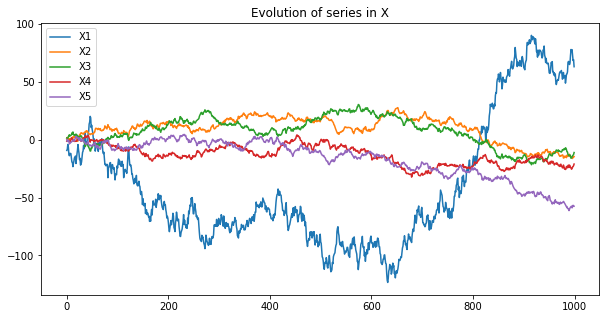

In [ ]:
np.random.seed(10)
series = generate_cointegrated_order1(num_series=5, num_coint_series=3, size=1000)
series.plot(figsize=(10,5), title='Evolution of series in X');

Now we make sure the linear combination of $X1$, $X2$ and $X3$ is stationary by plotting it.

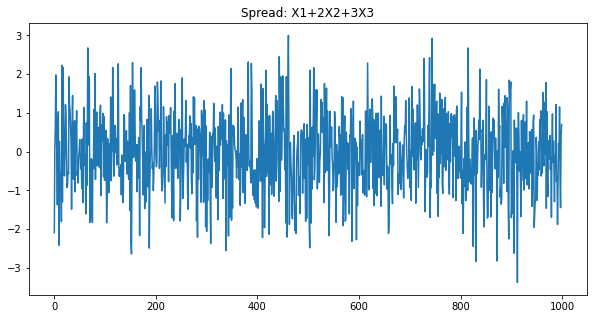

In [ ]:
spread = series['X1'] + 2*series['X2'] + 3*series['X3']
spread.plot(figsize=(10,5), title='Spread: X1+2X2+3X3');

The next step will be to perform the Johansen tests in order to calculate the number of cointegration vectors. 
The Johansen test implementation in python fits the model and saves into the JohansenTestResult object all the key outputs from the test, including both the outputs from the trace and the maximum eigenvalue tests.

To fit the model we only need: 
*   The series of $X$
*   The deterministic order (det_order) that can be set to $-1$ for no deterministic terms, $0$ for only constant term or $1$ for constant and linear trend.
*   The differenciation order for the model (k_ar_diff), that is, the number of lags to be considered.

For the moment, we will fit the model on our synthetic data considering no deterministic terms and with no lags, as this is how we created the synthetic series.



In [ ]:
johansen = coint_johansen(series, det_order=-1, k_ar_diff=0)

We will also create a function to show the test results in a more ordered manner later on.

In [1]:
def tabulate_johansen_test(method, statistic, critical_values):
  print('\033[1m' + method + '\033[0m' + '\n')
  print(f"\033[1m{'H0': <10}{'Statistic': >10}{'90% CV': >10}{'95% CV': >10}{'99% CV': >10}\033[0m")
  print('--'*26)
  for i in range(statistic.shape[0]):
    print(f"Rank(Π)={i}".ljust(10),
          f"{statistic[i]:.2f}".rjust(10),
          f"{critical_values[i,0]:.2f}".rjust(10),
          f"{critical_values[i,1]:.2f}".rjust(10),
          f"{critical_values[i,2]:.2f}".rjust(10), sep='')

**The trace test**\
This methodology uses the statistic $-T\sum_{i=r+1}^p ln(1-\hat{λ}_i)$ and the null hypothesis is that the rank of $Π$ is $r$ versus the alternative that $r< rank(Π)\leq p$ where $p$ is the maximum number of possible cointegrating vectors. If the rank of $Π$ is $r$ then this is the number of cointegrating relationships for $X$. This test can also be interpreted as testing $\hat{λ}_r=0$ versus the alternative $\hat{λ}_{r^*}=0$ with $r< r^* \leq p$.

We can arrive to a conclussion on the rank of $Π$ by succesively performing the test. That is, first we test for $rank(Π)=0$ versus the alternative $0< rank(Π)\leq p$. If we cannot reject $H_0$ then there is no cointegration and we are done. Otherwise, the largest eigenvalue $\hat{λ}_1$ (and maybe some more) is different from zero, the rank of $Π$ is at least one and we can find more cointegrating relationships. 

Now we test for $rank(Π)=1$ versus the alternative $1< rank(Π)\leq p$. If we cannot reject $H_0$ then there is only one cointegrating vector and we are done. Otherwise, the second largest eigenvalue $\hat{λ}_2$ (and maybe some more) is different from zero, the rank of $Π$ is at least two and we can find more cointegrating relationships. We follow this process until we can conclude on the rank of $Π$ and therefore, on the number of cointegrating vectors.

If we analyze the trace test on the synthetic series, we would expect that only the first test passes, that is, $rank(Π)=1$. The Johansen test implementation already performs all the test for each null hypothesis from $rank(Π)=0$ to $rank(Π)=p$ where $p$ repesents the maximum possible range for $Π$, that is, the total number of series but one.

We can access all the trace statistic values and their critical values by using the attributes **lr1** and **cvt** respectively on the JohansenTestResult.

In [ ]:
trace_statistics = johansen.lr1
critical_values_trace = johansen.cvt
tabulate_johansen_test('Trace statistic', trace_statistics, critical_values_trace)

Trace statistic

H0         Statistic    90% CV    95% CV    99% CV
----------------------------------------------------
Rank(Π)=0     710.75     56.28     60.06     67.64
Rank(Π)=1      33.88     37.03     40.17     46.57
Rank(Π)=2      20.18     21.78     24.28     29.51
Rank(Π)=3       8.38     10.47     12.32     16.36
Rank(Π)=4       1.90      2.98      4.13      6.94


We can observe that only the first test fails for any confidence level, that is, we can always reject that there is no cointegration relationship. But we cannot reject any of the following tests. Therefore, we conclude that there is only one cointegrating vector (as we were expecting).

**The maximum eigenvalue test**\
This methodology uses the statistic $-T ln(1-\hat{λ}_{r-1})$ and the null hypothesis is that the rank of $Π$ is $r$ versus the alternative that the rank of $Π$ is $r+1$. If the rank of $Π$ is $r$ then this is the number of cointegrating relationships for $X$. This test can also be interpreted as testing $\hat{λ}_r=0$ versus the alternative $\hat{λ}_{r+1}=0$. 

We can arrive to a conclussion on the rank of $Π$ by succesively performing the test. That is, first we test for $rank(Π)=0$ versus the alternative $rank(Π)=1$. If we cannot reject $H_0$ then there is no cointegration and we are done. Otherwise, the largest eigenvalue $\hat{λ}_1$ is different from zero, the rank of $Π$ is at least one and we can find more cointegrating relationships. 

Now we test for $rank(Π)=1$ versus the alternative $rank(Π)=2$. If we cannot reject $H_0$ then there is only one cointegrating vector and we are done. Otherwise, the second largest eigenvalue $\hat{λ}_2$ is different from zero, the rank of $Π$ is at least two and we can find more cointegrating relationships. We follow this process until we can conclude on the rank of $Π$ and therefore, on the number of cointegrating vectors.

However, using this approach with the maximum eigenvalue test is not consistent and may lead to underestimating the number of cointegrating vectors. As a consequence, it is better to use the trace test for the purpose of finding the rank of $Π$.

If we analyze the maximum eigenvalue test on the synthetic series, we would expect that only the first test passes, that is, $rank(Π)=1$. The Johansen test implementation already performs all the test for each null hypothesis from $rank(Π)=0$ to $rank(Π)=p$ where $p$ repesents the maximum possible range for $Π$, that is, the total number of series but one.

We can access all the maximum eigenvalue statistic values and their critical values by using the attributes **lr2** and **cvm** respectively on the JohansenTestResult.

In [ ]:
max_eig_statistics = johansen.lr2
critical_values_max_eig = johansen.cvm
tabulate_johansen_test('Trace statistic', max_eig_statistics, critical_values_max_eig)

Trace statistic

H0         Statistic    90% CV    95% CV    99% CV
----------------------------------------------------
Rank(Π)=0     676.88     27.92     30.44     35.74
Rank(Π)=1      13.69     21.84     24.16     29.06
Rank(Π)=2      11.81     15.72     17.80     22.25
Rank(Π)=3       6.48      9.47     11.22     15.09
Rank(Π)=4       1.90      2.98      4.13      6.94


We can observe that only the first test fails for any confidence level, that is, we can always reject that there is no cointegration relationship. But we cannot reject any of the following tests. Therefore, we conclude that there is only one cointegrating vector (as we were expecting).

The trace test and the maximum eigenvalue test tend to be coincident in their conclusions (as it is the case). However; in case of discrepancy is the trace test the one that should be preferred.

### 3.3 Finding the cointegrating vectors
As we have developed above, we are only interested on the eigenvectors associated to the non-zero eigenvalues. The order of $Π$ detected via the trace or the maximum eigenvalue test is telling us precisely how many eigenvectors we can consider to be cointegrating vectors.

It is important to note that, in case we have more than one cointegrating vector, all of them represent valid independent cointegrating relations, and we can use any (or all) of them to construct stationary series.

The Johansen test implementation already outputs the eigenvalues in descending order. The eigenvectors are also ordered to be in the same position as their associated eigenvalue.

In [ ]:
# Define some variables to express more graphically eigenvalues and eigenvectors

def tabulate_eigenvalues(eigenvalues):
  print('\033[1m' + 'Eigenvalues' + '\033[0m' + '\n')
  print(f"\033[1m{'λ1': >10}{'λ2': >10}{'λ3': >10}{'λ4': >10}{'λ5': >10}\033[0m")
  print('--'*26)
  eigenvalue_str = ''
  for eigenvalue in eigenvalues:
    eigenvalue_str += f"{eigenvalue:.2f}".rjust(10)
  print(eigenvalue_str)


def tabulate_eigenvectors(eigenvectors):
  print('\033[1m' + 'Eigenvectors' + '\033[0m' + '\n')
  print(f"\033[1m{'v1': >10}{'v2': >10}{'v3': >10}{'v4': >10}{'v5': >10}\033[0m")
  print('--'*26)
  for eigenvector in eigenvectors:
    eigenvector_str = ''
    for value in eigenvector:
      eigenvector_str += f"{value:.2f}".rjust(10)
    print(eigenvector_str)


def cointegrating_vectors_analysis(eigenvalues, eigenvectors):
  tabulate_eigenvalues(eigenvalues)
  print('\n')
  tabulate_eigenvectors(eigenvectors)

We can access the eigenvalues of the Johansen test by using the attribute **eig** on the JohansenTestResult. In this case we can corroborate that the only one seeming to be statistically different from zero is the first one.

In [ ]:
eigenvalues = johansen.eig.round(2)
tabulate_eigenvalues(eigenvalues)

Eigenvalues

        λ1        λ2        λ3        λ4        λ5
----------------------------------------------------
      0.49      0.01      0.01      0.01      0.00


The JohansenTestResult also contains the test eigenvalues ordered by columns. In this case we can see that the first eigenvector is in fact the one we defined when creating the synthetic data. That is, we can create a stationary series by taking $X1+2X2+3X3+0X4+0X5$.

In [ ]:
eigenvectors = johansen.evec.round(2)
tabulate_eigenvectors(eigenvectors)

Eigenvectors

        v1        v2        v3        v4        v5
----------------------------------------------------
      1.00      0.01      0.01     -0.00      0.00
      2.00      0.10      0.06      0.10      0.03
      3.00      0.02      0.02     -0.12      0.05
     -0.00      0.14      0.07     -0.03     -0.02
     -0.00     -0.09      0.00      0.03      0.01


Putting it all together, we can observe that we should only consider the first eigenvector ($v_1$) since this is the one associated to the only non-zero eigenvalue ($λ_1$).

In [ ]:
cointegrating_vectors_analysis(eigenvalues, eigenvectors)

Eigenvalues

        λ1        λ2        λ3        λ4        λ5
----------------------------------------------------
      0.49      0.01      0.01      0.01      0.00


Eigenvectors

        v1        v2        v3        v4        v5
----------------------------------------------------
      1.00      0.01      0.01     -0.00      0.00
      2.00      0.10      0.06      0.10      0.03
      3.00      0.02      0.02     -0.12      0.05
     -0.00      0.14      0.07     -0.03     -0.02
     -0.00     -0.09      0.00      0.03      0.01


We can generate a synthetic series (in this case the one we simmulated when creating the synthetic data) by multiplying the time series by the first eigenvector. Note we need dot (or matrix) multiplication in order to get only one time series.

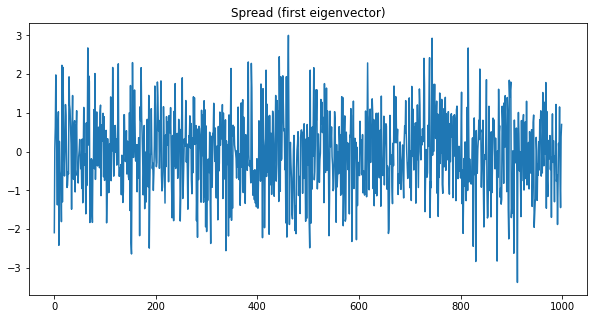

In [ ]:
first_eigenvector = eigenvectors[:, 0]
spread = series.dot(first_eigenvector)
spread.plot(figsize=(10,5), title='Spread (first eigenvector)');

### 3.3 Selecting the optimal number of lags
One of the key hyperparameters for the Johansen test is the highest differenciation order considered in the model, since the fitting is very sensitive to different number of lags.

To help us decide about the optimim number of lags, the same library implementing the Johansen test provide us with the function select_order. This function analyzes all the possible lags from zero to the input maxlags and selects the best choice based on AIC, BIC, FPE and HQIC.

Below we can find the summary output of the LagOrderResults object showing all the scores by information criteria and by lag order. It is worth noting that the best possible lag order for the Johansen model is clearly zero, since this is how we simmulated the synthetic data.

In [ ]:
order_info = select_order(series, maxlags=10)
print(order_info.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0    -0.09482*    0.05371*     0.9095*   -0.03834*
1     -0.06947      0.2028      0.9329     0.03408
2     -0.06246      0.3336      0.9395     0.08817
3     -0.03477      0.4851      0.9659      0.1629
4     -0.01531      0.6283      0.9849      0.2295
5      0.01422      0.7816       1.014      0.3061
6      0.03687      0.9281       1.038      0.3758
7      0.06360       1.079       1.066      0.4496
8      0.09050       1.229       1.095      0.5235
9       0.1125       1.375       1.120      0.5927
10      0.1462       1.533       1.158      0.6734
--------------------------------------------------


If we only want to access the best selected order by information criteria, we can do so by using the attribute **selected_orders** on the LagOrderResults object. This returns a dictionary from which we can return the optimum lag value for any method.

In [ ]:
print(order_info.selected_orders)

{'aic': 0, 'bic': 0, 'hqic': 0, 'fpe': 0}


# References
[Cointegration and VAR] https://www.bauer.uh.edu/rsusmel/phd/ec2-7.pdf<br/>
[VAR Models] https://www.aptech.com/blog/introduction-to-the-fundamentals-of-vector-autoregressive-models/<br/>
[Granger-Engle representation Theorem] https://www.uio.no/studier/emner/sv/oekonomi/ECON5101/v11/undervisningsmateriale/LN4EGtheorem.pdf<br/>
[Johansen test] https://www.uh.edu/~bsorense/coint.pdf<br/>
[Johansen test (Chapter 6.1)] https://drive.google.com/file/d/1yv_wZhapqw0ywAu6UaGNXv-sGCqLRH_5/view?usp=sharing<br/>
[Trace and max-eigenvalue tests] http://www.jerrydwyer.com/pdf/Clemson/Cointegration.pdf <br/>